In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
#cifar10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 7s 0us/step


## **Denoising**

In [ ]:
def preprocess_images(images):
    return images.astype(np.float32) / 255.0

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

train_images = preprocess_images(x_train)
test_images = preprocess_images(x_test)
train_labels = preprocess_labels(y_train)
test_labels = preprocess_labels(y_test)

batch_size=128
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(train_images.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(test_images.shape[0]).batch(batch_size)

In [ ]:
#add noise and set x as label
noise_layer = tf.keras.layers.GaussianNoise(stddev=0.1)
noise_data = train_data.map(lambda x, y: (tf.math.maximum(tf.math.minimum(noise_layer(x, training=True), 1.0), 0.0), x))

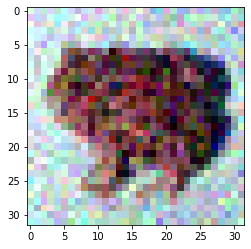

In [ ]:
for image, label in noise_data.take(1):
    plt.imshow(image[0])

In [ ]:
encoder = tf.keras.Sequential(name="encoder", 
                              layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                      tf.keras.layers.Conv2D(1, 9, padding='valid',  activation='sigmoid')])

decoder = tf.keras.Sequential(name="decoder",
                              layers=[tf.keras.layers.Conv2DTranspose(1, 9, padding='valid',  activation='sigmoid', input_shape=(8, 8, 1)),
                                      tf.keras.layers.Conv2DTranspose(3, 17, padding='valid', activation='sigmoid')]) 

autoencoder = tf.keras.Sequential(name="autoencoder", layers=[encoder, decoder])

classification_head = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(8, 8, 1)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head])


classifier = tf.keras.Sequential(name="classifier",
                                 layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                         tf.keras.layers.Conv2D(1, 9, padding='valid', activation='sigmoid'),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(10)])

autoencoder.summary(expand_nested=True)
pretrained_classifier.summary(expand_nested=True)
classifier.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8, 8, 1)           950       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_10 (Conv2D)        (None, 16, 16, 1)         868       |
|                                                               |
| conv2d_11 (Conv2D)        (None, 8, 8, 1)           82        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Sequential)        (None, 32, 32, 3)         952       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_transpose_4 (Conv2DT  (None, 16, 16, 1)      82        |
| ranspose)                                                     |
|                                                               |
| conv2d_transpose_5 (Conv2DT  (None, 32, 32, 3)      870       |
| ranspose)                                            

In [ ]:
print("Encoder, autoencoder and pretrained classifier are using the same variables.")
print(encoder.trainable_variables == autoencoder.get_layer("encoder").trainable_variables == pretrained_classifier.get_layer("encoder").trainable_variables)
print("The classifier doesn't use the same variables.")
print(tf.reduce_all(pretrained_classifier.get_layer("encoder").get_layer(index=0).trainable_variables[0] == classifier.get_layer(index=0).trainable_variables[0]))

Encoder, autoencoder and pretrained classifier are using the same variables.
True
The classifier doesn't use the same variables.
tf.Tensor(False, shape=(), dtype=bool)


In [ ]:
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss=tf.losses.MeanSquaredError())

pretrained_classifier.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
autoencoder.fit(noise_data, epochs=25)

Epoch 1/25
391/391 [==============================] - 9s 21ms/step - loss: 0.0599
Epoch 2/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0573
Epoch 3/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0561
Epoch 4/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0548
Epoch 5/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0534
Epoch 6/25
391/391 [==============================] - 8s 19ms/step - loss: 0.0515
Epoch 7/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0490
Epoch 8/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0475
Epoch 9/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0468
Epoch 10/25
391/391 [==============================] - 8s 21ms/step - loss: 0.0465
Epoch 11/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0462
Epoch 12/25
391/391 [==============================] - 8s 20ms/step - loss: 0.0460
Epoch 13/25
3

In [ ]:
encoder.trainable = False
pretrained_classifier.fit(train_data, epochs=25)
pretrained_classifier.evaluate(test_data)

Epoch 1/25
391/391 [==============================] - 3s 5ms/step - loss: 2.1821 - sparse_categorical_accuracy: 0.1933
Epoch 2/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0717 - sparse_categorical_accuracy: 0.2431
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0298 - sparse_categorical_accuracy: 0.2468
Epoch 4/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0067 - sparse_categorical_accuracy: 0.2489
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 1.9883 - sparse_categorical_accuracy: 0.2542
Epoch 6/25
391/391 [==============================] - 2s 5ms/step - loss: 1.9795 - sparse_categorical_accuracy: 0.2544
Epoch 7/25
391/391 [==============================] - 2s 5ms/step - loss: 1.9702 - sparse_categorical_accuracy: 0.2555
Epoch 8/25
391/391 [==============================] - 2s 5ms/step - loss: 1.9634 - sparse_categorical_accuracy: 0.2562
Epoch 9/25
391/391 [============================

[1.9153529405593872, 0.2752000093460083]

In [ ]:
classifier.fit(train_data, epochs=25)
classifier.evaluate(test_data)

Epoch 1/25
391/391 [==============================] - 3s 5ms/step - loss: 2.3041 - sparse_categorical_accuracy: 0.1011
Epoch 2/25
391/391 [==============================] - 2s 5ms/step - loss: 2.1717 - sparse_categorical_accuracy: 0.1944
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0784 - sparse_categorical_accuracy: 0.2259
Epoch 4/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0425 - sparse_categorical_accuracy: 0.2293
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0228 - sparse_categorical_accuracy: 0.2348
Epoch 6/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0095 - sparse_categorical_accuracy: 0.2398
Epoch 7/25
391/391 [==============================] - 2s 5ms/step - loss: 2.0010 - sparse_categorical_accuracy: 0.2414
Epoch 8/25
391/391 [==============================] - 2s 5ms/step - loss: 1.9925 - sparse_categorical_accuracy: 0.2470
Epoch 9/25
391/391 [============================

[1.9222583770751953, 0.2797999978065491]

In [ ]:
labeled_indices = np.random.choice(train_images.shape[0], replace=False, size=1000)
image_subset = train_images[labeled_indices]
label_subset = train_labels[labeled_indices]
train_subset_data = tf.data.Dataset.from_tensor_slices((image_subset, label_subset)).shuffle(image_subset.shape[0]).batch(batch_size)

classification_head_subset = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(8, 8, 1)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier_subset = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head_subset])


classifier_subset = tf.keras.Sequential(name="classifier",
                                 layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                         tf.keras.layers.Conv2D(1, 9, padding='valid', activation='sigmoid'),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(10)])

pretrained_classifier_subset.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier_subset.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

pretrained_classifier_subset.fit(train_subset_data, epochs=25)
pretrained_classifier_subset.evaluate(test_data)

classifier_subset.fit(train_subset_data, epochs=25)
classifier_subset.evaluate(test_data)

Epoch 1/25
8/8 [==============================] - 1s 12ms/step - loss: 2.4301 - sparse_categorical_accuracy: 0.1060
Epoch 2/25
8/8 [==============================] - 0s 5ms/step - loss: 2.3376 - sparse_categorical_accuracy: 0.1040
Epoch 3/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2797 - sparse_categorical_accuracy: 0.1060
Epoch 4/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2417 - sparse_categorical_accuracy: 0.1170
Epoch 5/25
8/8 [==============================] - 0s 9ms/step - loss: 2.2219 - sparse_categorical_accuracy: 0.1170
Epoch 6/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2078 - sparse_categorical_accuracy: 0.1470
Epoch 7/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2014 - sparse_categorical_accuracy: 0.1530
Epoch 8/25
8/8 [==============================] - 0s 7ms/step - loss: 2.1962 - sparse_categorical_accuracy: 0.1580
Epoch 9/25
8/8 [==============================] - 0s 7ms/step - loss: 2.1921 - 

[2.3057682514190674, 0.10220000147819519]

## **Masking**

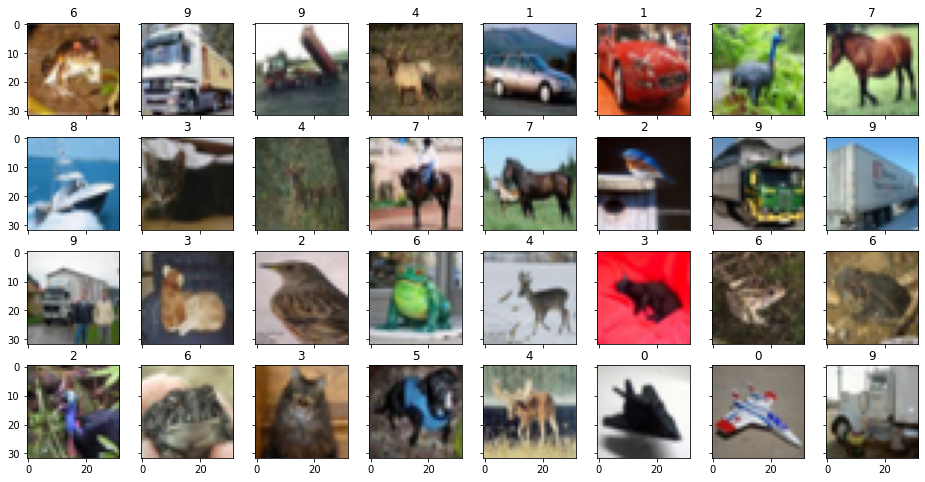

In [ ]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(tf.keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
traingen = createAugment(x_train,x_train)
testgen = createAugment(x_test,x_test,shuffle=False)

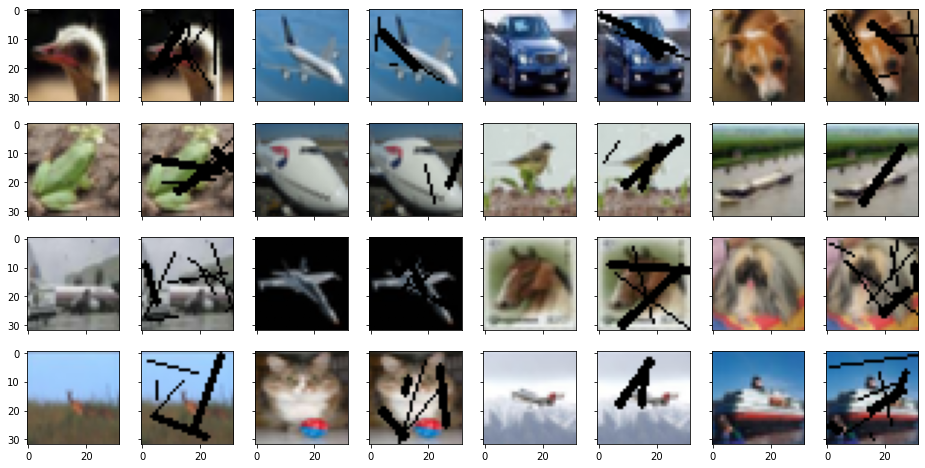

In [ ]:
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
encoder = tf.keras.Sequential(name="encoder", 
                              layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                      tf.keras.layers.Conv2D(1, 9, padding='valid',  activation='sigmoid')])

decoder = tf.keras.Sequential(name="decoder",
                              layers=[tf.keras.layers.Conv2DTranspose(1, 9, padding='valid',  activation='sigmoid', input_shape=(8, 8, 1)),
                                      tf.keras.layers.Conv2DTranspose(3, 17, padding='valid', activation='sigmoid')]) 

autoencoder = tf.keras.Sequential(name="autoencoder", layers=[encoder, decoder])

classification_head = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(8, 8, 1)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head])


classifier = tf.keras.Sequential(name="classifier",
                                 layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                         tf.keras.layers.Conv2D(1, 9, padding='valid', activation='sigmoid'),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(10)])

autoencoder.summary(expand_nested=True)
pretrained_classifier.summary(expand_nested=True)
classifier.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8, 8, 1)           950       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_16 (Conv2D)        (None, 16, 16, 1)         868       |
|                                                               |
| conv2d_17 (Conv2D)        (None, 8, 8, 1)           82        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Sequential)        (None, 32, 32, 3)         952       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_transpose_6 (Conv2DT  (None, 16, 16, 1)      82        |
| ranspose)                                                     |
|                                                               |
| conv2d_transpose_7 (Conv2DT  (None, 32, 32, 3)      870       |
| ranspose)                                            

In [ ]:
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss=tf.losses.MeanSquaredError())

pretrained_classifier.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
autoencoder.fit(traingen, epochs=25)

Epoch 1/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0584
Epoch 2/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0526
Epoch 3/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0508
Epoch 4/25
1562/1562 [==============================] - 18s 12ms/step - loss: 0.0500
Epoch 5/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0496
Epoch 6/25
1562/1562 [==============================] - 18s 12ms/step - loss: 0.0494
Epoch 7/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0493
Epoch 8/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0491
Epoch 9/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0490
Epoch 10/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.0490
Epoch 11/25
1562/1562 [==============================] - 18s 12ms/step - loss: 0.0489
Epoch 12/25
1562/1562 [==============================] - 19s 12

In [ ]:
encoder.trainable = False
pretrained_classifier.fit(train_data, epochs=25)
pretrained_classifier.evaluate(test_data)

Epoch 1/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9779 - sparse_categorical_accuracy: 0.2653
Epoch 2/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9691 - sparse_categorical_accuracy: 0.2700
Epoch 3/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9648 - sparse_categorical_accuracy: 0.2720
Epoch 4/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9620 - sparse_categorical_accuracy: 0.2744
Epoch 5/25
1563/1563 [==============================] - 7s 5ms/step - loss: 1.9585 - sparse_categorical_accuracy: 0.2757
Epoch 6/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9543 - sparse_categorical_accuracy: 0.2762
Epoch 7/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9526 - sparse_categorical_accuracy: 0.2773
Epoch 8/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9495 - sparse_categorical_accuracy: 0.2797
Epoch 9/25
1563/1563 [==========

[1.908511757850647, 0.28439998626708984]

In [ ]:
classifier.fit(train_data, epochs=25)
classifier.evaluate(test_data)

Epoch 1/25
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9940 - sparse_categorical_accuracy: 0.2503
Epoch 2/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9837 - sparse_categorical_accuracy: 0.2562
Epoch 3/25
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9796 - sparse_categorical_accuracy: 0.2575
Epoch 4/25
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9730 - sparse_categorical_accuracy: 0.2580
Epoch 5/25
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9718 - sparse_categorical_accuracy: 0.2605
Epoch 6/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9658 - sparse_categorical_accuracy: 0.2645
Epoch 7/25
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9636 - sparse_categorical_accuracy: 0.2647
Epoch 8/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9589 - sparse_categorical_accuracy: 0.2658
Epoch 9/25
1563/1563 [==========

[1.9138566255569458, 0.28540000319480896]

In [ ]:
labeled_indices = np.random.choice(train_images.shape[0], replace=False, size=1000)
image_subset = train_images[labeled_indices]
label_subset = train_labels[labeled_indices]
train_subset_data = tf.data.Dataset.from_tensor_slices((image_subset, label_subset)).shuffle(image_subset.shape[0]).batch(batch_size)

classification_head_subset = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(8, 8, 1)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier_subset = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head_subset])


classifier_subset = tf.keras.Sequential(name="classifier",
                                 layers=[tf.keras.layers.Conv2D(1, 17, padding='valid', activation='sigmoid', input_shape=(32,32,3)),
                                         tf.keras.layers.Conv2D(1, 9, padding='valid', activation='sigmoid'),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(10)])

pretrained_classifier_subset.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier_subset.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

pretrained_classifier_subset.fit(train_subset_data, epochs=25)
pretrained_classifier_subset.evaluate(test_data)

classifier_subset.fit(train_subset_data, epochs=25)
classifier_subset.evaluate(test_data)

Epoch 1/25
32/32 [==============================] - 0s 3ms/step - loss: 2.3424 - sparse_categorical_accuracy: 0.1030
Epoch 2/25
32/32 [==============================] - 0s 3ms/step - loss: 2.2367 - sparse_categorical_accuracy: 0.1200
Epoch 3/25
32/32 [==============================] - 0s 4ms/step - loss: 2.2279 - sparse_categorical_accuracy: 0.1120
Epoch 4/25
32/32 [==============================] - 0s 3ms/step - loss: 2.2221 - sparse_categorical_accuracy: 0.1190
Epoch 5/25
32/32 [==============================] - 0s 4ms/step - loss: 2.2139 - sparse_categorical_accuracy: 0.1180
Epoch 6/25
32/32 [==============================] - 0s 4ms/step - loss: 2.2074 - sparse_categorical_accuracy: 0.1220
Epoch 7/25
32/32 [==============================] - 0s 3ms/step - loss: 2.2030 - sparse_categorical_accuracy: 0.1290
Epoch 8/25
32/32 [==============================] - 0s 4ms/step - loss: 2.1951 - sparse_categorical_accuracy: 0.1120
Epoch 9/25
32/32 [==============================] - 0s 4ms/step 

[2.131700277328491, 0.23080000281333923]

MNIST DATASET

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPooling2D, UpSampling2D, Flatten, Activation, Reshape
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10
from IPython import display

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def preprocess_images(images):
    return (images.astype(np.float32) / 255.0).reshape((len(images), 28, 28, 1))

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

x_train = preprocess_images(x_train)
print(x_train.shape)
x_test = preprocess_images(x_test)
print(x_test.shape)
y_train = preprocess_labels(y_train)
print(y_train.shape)
y_test = preprocess_labels(y_test)
print(y_test.shape)

batch_size=128
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(x_test.shape[0]).batch(batch_size)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [ ]:
# Adding noise to data
noise = 0.3
train_noise = x_train + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
    )
test_noise = x_test + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
    )

train_noise = np.clip(train_noise, 0., 1.)
test_noise = np.clip(test_noise, 0., 1.)

def visualise_images(array1, array2):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

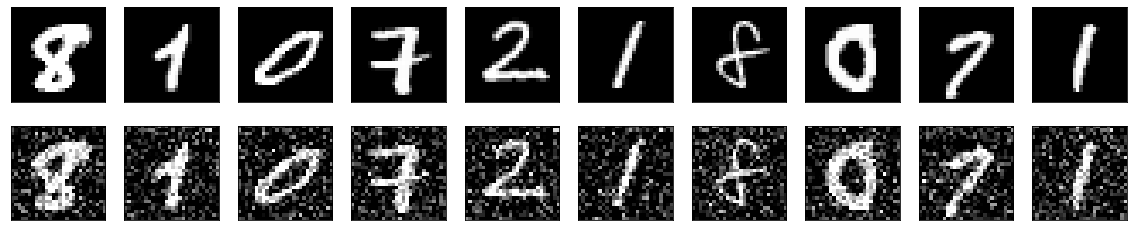

In [ ]:
visualise_images(x_train,train_noise)

In [ ]:
encoder = Sequential(name="encoder", 
                              layers=[Conv2D(16, (3, 3), padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
                                         MaxPooling2D((2, 2), padding='same'),
                                         Conv2D(2, (3, 3), activation='sigmoid', padding='same'),
                                         MaxPooling2D((2, 2), padding='same'),
                                      ])
decoder = Sequential(name="decoder",
                              layers=[Conv2D(2, (3, 3), padding='same',  activation='sigmoid', input_shape=(7, 7, 2)),
                                      UpSampling2D((2, 2)),
                                      Conv2D(16, (3, 3), padding='same',  activation='sigmoid'),
                                      UpSampling2D((2, 2)),
                                      layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
                                      ]) 

autoencoder = Sequential(name="autoencoder", layers=[encoder, decoder])

autoencoder.summary(expand_nested=True)

classification_head = Sequential(name="classification_head", 
                                          layers=[Flatten(input_shape=(7, 7, 2)),
                                                   Dense(10)])
pretrained_classifier = Sequential(name="encoder_classifier", layers=[encoder, classification_head])

classifier = Sequential(name="classifier",
                                 layers=[Conv2D(16, (3, 3), padding='same', 
                                                activation='sigmoid', 
                                                input_shape=(28, 28, 1)),
                                        MaxPooling2D((2, 2), 
                                                     padding='same'),
                                        Conv2D(2, (3, 3), activation='sigmoid', 
                                               padding='same'),
                                        MaxPooling2D((2, 2), padding='same'),
                                         Flatten(),
                                         Dense(10)])

pretrained_classifier.summary(expand_nested=True)
classifier.summary(expand_nested=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 7, 7, 2)           450       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_7 (Conv2D)         (None, 28, 28, 16)        160       |
|                                                               |
| max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)     0         |
| 2D)                                                           |
|                                                               |
| conv2d_8 (Conv2D)         (None, 14, 14, 2)         290       |
|                                                               |
| max_pooling2d_5 (MaxPooling  (None, 7, 7, 2)        0         |
| 2D)                                                           |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Sequential)        (None, 28, 28, 1)         

In [ ]:
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss=tf.losses.BinaryCrossentropy())

pretrained_classifier.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
autoencoder.fit(x_train,x_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0977
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0971
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0967
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0965
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0963
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0961
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0959
Epoch 8/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0957
Epoch 9/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0954
Epoch 10/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0952
Epoch 11/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0950
Epoch 12/20
1875/1875 [==============================] - 11s 6ms/step - lo

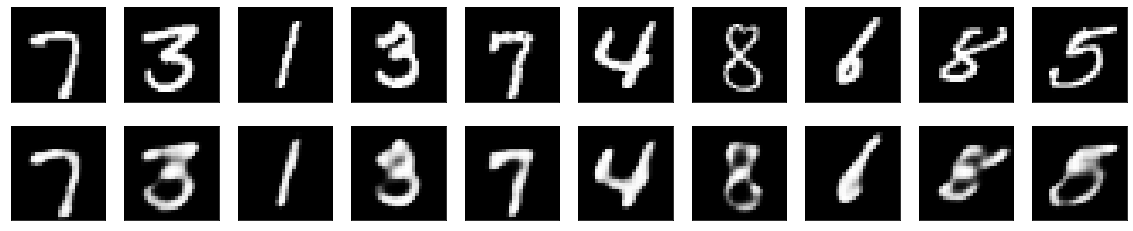

In [ ]:
predictions = autoencoder.predict(x_test)
visualise_images(x_test, predictions)

In [ ]:
encoder.trainable = False
pretrained_classifier.fit(train_data, epochs=25)
pretrained_classifier.evaluate(test_data)

Epoch 1/25
469/469 [==============================] - 3s 5ms/step - loss: 1.8631 - sparse_categorical_accuracy: 0.4844
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.7243
Epoch 3/25
469/469 [==============================] - 3s 5ms/step - loss: 0.9925 - sparse_categorical_accuracy: 0.7676
Epoch 4/25
469/469 [==============================] - 3s 5ms/step - loss: 0.8464 - sparse_categorical_accuracy: 0.7930
Epoch 5/25
469/469 [==============================] - 3s 5ms/step - loss: 0.7523 - sparse_categorical_accuracy: 0.8103
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.8251
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.8351
Epoch 8/25
469/469 [==============================] - 3s 5ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.8434
Epoch 9/25
469/469 [============================

[0.3760605454444885, 0.8964999914169312]

In [ ]:
classifier.fit(train_data, epochs=25)
classifier.evaluate(test_data)

Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 1.8855 - sparse_categorical_accuracy: 0.4256
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.8661 - sparse_categorical_accuracy: 0.7735
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.8184
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.5428 - sparse_categorical_accuracy: 0.8453
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.8626
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.4313 - sparse_categorical_accuracy: 0.8750
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8847
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3623 - sparse_categorical_accuracy: 0.8939
Epoch 9/25
469/469 [============================

[0.17272669076919556, 0.9487000107765198]

In [ ]:
labeled_indices = np.random.choice(x_train.shape[0], replace=False, size=1000)
image_subset = x_train[labeled_indices]
label_subset = y_train[labeled_indices]
train_subset_data = tf.data.Dataset.from_tensor_slices((image_subset, label_subset)).shuffle(image_subset.shape[0]).batch(batch_size)

classification_head_subset = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(7, 7, 2)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier_subset = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head_subset])


classifier_subset = tf.keras.Sequential(name="classifier",
                                 layers=[Conv2D(16, (3, 3), padding='same', 
                                                activation='sigmoid', 
                                                input_shape=(28, 28, 1)),
                                        MaxPooling2D((2, 2), 
                                                     padding='same'),
                                        Conv2D(2, (3, 3), activation='sigmoid', 
                                               padding='same'),
                                        MaxPooling2D((2, 2), padding='same'),
                                         Flatten(),
                                         Dense(10)])

pretrained_classifier_subset.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier_subset.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

pretrained_classifier_subset.fit(train_subset_data, epochs=25)
pretrained_classifier_subset.evaluate(test_data)

classifier_subset.fit(train_subset_data, epochs=25)
classifier_subset.evaluate(test_data)

Epoch 1/25
8/8 [==============================] - 1s 10ms/step - loss: 2.6226 - sparse_categorical_accuracy: 0.0780
Epoch 2/25
8/8 [==============================] - 0s 6ms/step - loss: 2.4411 - sparse_categorical_accuracy: 0.1290
Epoch 3/25
8/8 [==============================] - 0s 5ms/step - loss: 2.3361 - sparse_categorical_accuracy: 0.1500
Epoch 4/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2740 - sparse_categorical_accuracy: 0.1620
Epoch 5/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2438 - sparse_categorical_accuracy: 0.2090
Epoch 6/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2239 - sparse_categorical_accuracy: 0.2350
Epoch 7/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2066 - sparse_categorical_accuracy: 0.2390
Epoch 8/25
8/8 [==============================] - 0s 5ms/step - loss: 2.1866 - sparse_categorical_accuracy: 0.2510
Epoch 9/25
8/8 [==============================] - 0s 5ms/step - loss: 2.1680 - 

[2.295623779296875, 0.08609999716281891]